In [1]:
import math
import random
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod

# Monte Carlo approximation of the area of a circle with radius 1

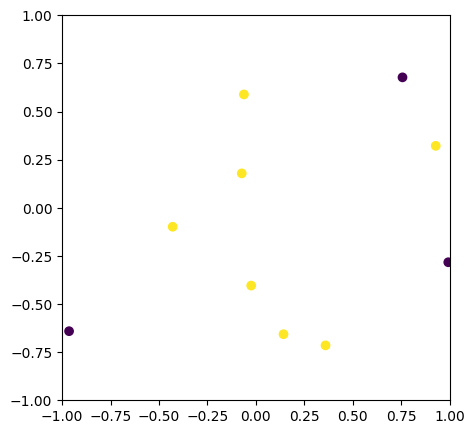

area ~= 2.8


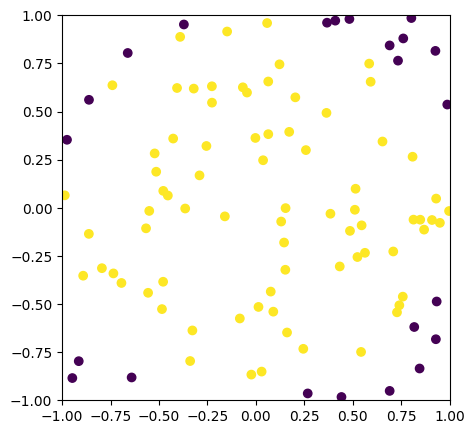

area ~= 3.08


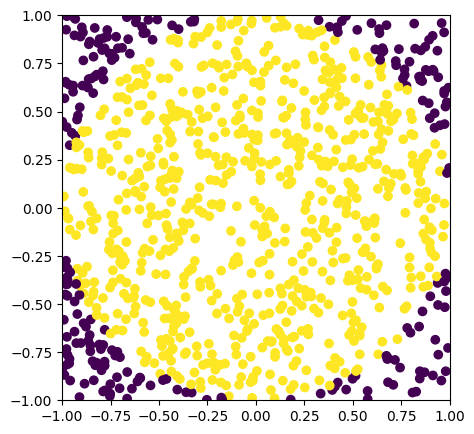

area ~= 3.044


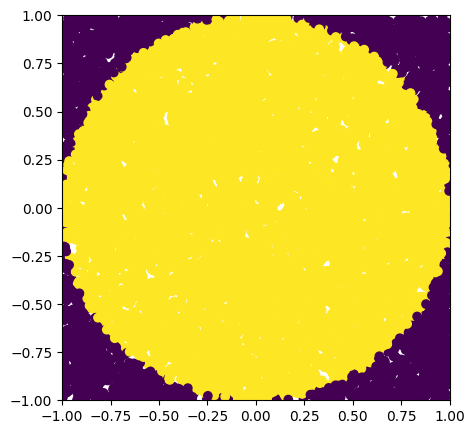

area ~= 3.1424


In [2]:
plt.rcParams["figure.figsize"] = (5,5)

for N in [10, 100, 1000, 10000]:
    # generate points in a 2x2 square
    pts = [[random.uniform(-1, 1), random.uniform(-1, 1)] for i in range(N)]
    inside = [0 if x**2+y**2 > 1 else 1 for x, y in pts]

    # show points
    plt.scatter([x for x,y in pts], [y for x,y in pts], c=inside)
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.show()

    # area approximation - square area multiplied by the percentage of points inside the circle
    area = 4*sum(inside)/N
    print('area ~=', area)

# Monte Carlo Tree Search implementation

<img src="mcts.png" width="600"/>

In [3]:
class MCTS():
    """
    MCTS implementation

    Methods
    -------
    search(state)
        Runs MCTS, and returns the best move for the current player.
    player_policy(state)
        Gets next player move for a given state.
    opponent_policy(state)
        Gets next opponent move for a given state.
    player_moves(state)
        Finds the list of successors for a given state.
    opponent_moves(state)
        Finds the list of successors for a given state.
    terminal_test(state)
        Checks if the given state is a terminal state.
    utility(state)
        Returns the utility value for the given state.
    """
    __metaclass__ = ABCMeta
    def __init__(self, num_playouts, c=1.41421356237):
        self.num_playouts = num_playouts
        self.c = c

    def __player_node_playout(self, state):
        if self.terminal_test(state):
            return self.utility(state)
        else:
            new_state = self.player_policy(state)
            return self.__opponent_node_playout(new_state)

    def __opponent_node_playout(self, state):
        if self.terminal_test(state):
            return self.utility(state)
        else:
            new_state = self.opponent_policy(state)
            return self.__player_node_playout(new_state)

    def __player_node(self, node): # 0:state, 1:action, 2:wins, 3:losses, 4:playouts, 5:children
        if self.terminal_test(node[0]):
            utility = self.utility(node[0])
        else:
            # if node was't expanded before,  prepare it for expansion
            if len(node[5]) == 0:
                moves = self.player_moves(node[0])
                random.shuffle(moves)
                for action, child in moves:
                    node[5].append([child, action, 0, 0, 0, []])

            # selection policy
            flag = False

            # pick unexpanded children first
            for i in range(len(node[5])):
                if node[5][i][4] == 0: # if the i-th child was never executed, choose it
                    utility = self.__opponent_node_playout(node[5][i][0])
                    node[5][i][4] += 1
                    if utility == 1:
                        node[5][i][2] += 1
                    elif utility == -1:
                        node[5][i][3] += 1
                    flag = True
                    break

            # move to best child if fully expanded
            if not flag:
                weights = [(wins-losses)/playouts + self.c*math.sqrt(math.log(node[4])/playouts) for _,_,wins,losses,playouts,_ in node[5]]
                i = -max((x,-j) for j,x in enumerate(weights))[1] # argmax
                node[5][i], utility = self.__opponent_node(node[5][i])

        # update playout stats
        node[4] += 1
        if utility == 1:
            node[3] += 1
        elif utility == -1:
            node[2] += 1

        return node, utility

    def __opponent_node(self, node): # 0:state, 1:action, 2:wins, 3:losses, 4:playouts, 5:children
        if self.terminal_test(node[0]):
            utility = self.utility(node[0])
        else:
            # if node was't expanded before,  prepare it for expansion
            if len(node[5]) == 0:
                moves = self.opponent_moves(node[0])
                random.shuffle(moves)
                for action, child in moves:
                    node[5].append([child, action, 0, 0, 0, []])

            # selection policy
            flag = False

            # pick unexpanded children first
            for i in range(len(node[5])):
                if node[5][i][4] == 0: # if the i-th child was never executed, choose it
                    utility = self.__player_node_playout(node[5][i][0])
                    node[5][i][4] += 1
                    if utility == 1:
                        node[5][i][3] += 1
                    elif utility == -1:
                        node[5][i][2] += 1
                    flag = True
                    break

            # move to best child if fully expanded
            if not flag:
                weights = [(wins-losses)/playouts + self.c*math.sqrt(math.log(node[4])/playouts) for _,_,wins,losses,playouts,_ in node[5]]
                i = -max((x,-j) for j,x in enumerate(weights))[1] # argmax
                node[5][i], utility = self.__player_node(node[5][i])

        # update playout stats
        node[4] += 1
        if utility == 1:
            node[2] += 1
        elif utility == -1:
            node[3] += 1

        return node, utility

    def search(self, state):
        """
        Runs MCTS, and returns the best move for the current player.

        Parameters
        ----------
        state
            A tuple describing a unique world configuration.

        Returns
        -------
        tuple
            A tuple describing the action to be taken.
        """
        root = [state, None, 0, 0, 0, []] # 0:state, 1:action, 2:wins, 3:losses, 4:playouts, 5:children
        for i in range(self.num_playouts):
            root, utility = self.__player_node(root)
        best_action = None
        best_child = -1
        for child in root[5]:
            print('{}: {} wins/{} losses/{} playouts'.format(child[1], child[2], child[3], child[4]))
            if child[4] > best_child: # pick the action with the highest number of playouts
                best_child = child[4]
                best_action = child[1]
        return best_action

    @abstractmethod
    def player_policy(self, state):
        """
        Gets next player move for a given state.

        Parameters
        ----------
        state
            A tuple describing a unique world configuration.

        Returns
        -------
        tuple
            A tuple describing a unique world configuration.
        """
        pass

    @abstractmethod
    def opponent_policy(self, state):
        """
        Gets next opponent move for a given state.

        Parameters
        ----------
        state
            A tuple describing a unique world configuration.

        Returns
        -------
        tuple
            A tuple describing a unique world configuration.
        """
        pass

    @abstractmethod
    def player_moves(self, state):
        """
        Finds the list of successors for a given state.

        Parameters
        ----------
        state
            A tuple describing a unique world configuration.

        Returns
        -------
        list
            A list of pairs (action,state) with all states that can be reached from the given state with a single action.
        """
        pass

    @abstractmethod
    def opponent_moves(self, state):
        """
        Finds the list of successors for a given state.

        Parameters
        ----------
        state
            A tuple describing a unique world configuration.

        Returns
        -------
        list
            A list of pairs (action,state) with all states that can be reached from the given state with a single action.
        """
        pass

    @abstractmethod
    def terminal_test(self, state):
        """
        Checks if the current state is a terminal state.

        Parameters
        ----------
        state
            A tuple describing a unique world configuration.

        Returns
        -------
        bool
             True if the given state is a terminal state, and False otherwise.
        """
        pass

    @abstractmethod
    def utility(self, state):
        """
        Returns the utility value for the given state.

        Parameters
        ----------
        state
            A tuple describing a unique world configuration.

        Returns
        -------
        int
             The utility value for the given state.
        """
        pass

# Tic-Tac-Toe

- A $3\times3$ array where two players put pieces on (**X** or **O**) in turns. Each player's goal is to fill one row, column, or diagonal with their pieces.

<img src="tictactoe.png" width="400"/>

In [4]:
class TicTacToe(MCTS):
    """
    TicTacToe solution using MCTS.

    Methods
    -------
    initial_state()
        Visualize a given state.
    show(state)
        Visualize a given state.
    player_move(state, action)
        Uses a given action to update a state of the board.
    opponent_move(state, action)
        Uses a given action to update a state of the board.
    player_moves(state)
        Finds the list of successors for a given state.
    opponent_moves(state)
        Finds the list of successors for a given state.
    terminal_test(state)
        Checks if the given state is a terminal state.
    utility(state)
        Returns the utility value for the given state.
    """
    def __init__(self, **kargs):
        super().__init__(num_playouts=(kargs['num_playouts'] if 'num_playouts' in kargs else 100), c=(kargs['c'] if 'c' in kargs else 1.41421356237))

    def initial_state(self):
        return ((' ',' ',' '),(' ',' ',' '),(' ',' ',' '))

    def show(self, state):
        """
        Visualize a given state.
        """
        for i in range(3):
            print('', end=' ')
            for j in range(3):
                print(state[i][j], end=' ')
                if j < 2:
                    print('║', end=' ')
            print()
            if i < 2:
                print('═══╬═══╬═══')
        print()

    def __get_random_move(self, state):
        actions = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == ' ':
                    actions.append((i,j))
        return random.choice(actions)

    def player_policy(self, state):
        """
        Gets next player move for a given state.

        Parameters
        ----------
        state
            A tuple describing a unique world configuration.

        Returns
        -------
        tuple
            A tuple describing a unique world configuration.
        """
        return self.player_move(state, self.__get_random_move(state))

    def opponent_policy(self, state):
        """
        Gets next opponent move for a given state.

        Parameters
        ----------
        state
            A tuple describing a unique world configuration.

        Returns
        -------
        tuple
            A tuple describing a unique world configuration.
        """
        return self.opponent_move(state, self.__get_random_move(state))

    def player_move(self, state, action):
        """
        Uses a given action to update a state of the board. Assumes the action is valid.
        """
        a, b = action
        state = [list(x) for x in state]
        state[a][b] = 'X'
        state = tuple(tuple(x) for x in state)
        return state

    def opponent_move(self, state, action):
        """
        Uses a given action to update a state of the board. Assumes the action is valid.
        """
        a, b = action
        state = [list(x) for x in state]
        state[a][b] = 'O'
        state = tuple(tuple(x) for x in state)
        return state

    def __successor(self, state, actor):
        successors = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == ' ':
                    neighbor_state = [list(x) for x in state]
                    neighbor_state[i][j] = actor
                    neighbor_state = tuple(tuple(x) for x in neighbor_state)
                    successors.append(((i,j), neighbor_state))
        return successors

    def player_moves(self, state):
        """
        Finds the list of successors for a given state.

        Parameters
        ----------
        state
            A tuple describing a unique world configuration.

        Returns
        -------
        list
            A list of pairs (action,state) with all states that can be reached from the given state with a single action.
        """
        return self.__successor(state, 'X')

    def opponent_moves(self, state):
        """
        Finds the list of successors for a given state.

        Parameters
        ----------
        state
            A tuple describing a unique world configuration.

        Returns
        -------
        list
            A list of pairs (action,state) with all states that can be reached from the given state with a single action.
        """
        return self.__successor(state, 'O')

    def terminal_test(self, state):
        """
        Checks if the current state is a terminal state.

        Parameters
        ----------
        state
            A tuple describing a unique world configuration.

        Returns
        -------
        bool
             True if the given state is a terminal state, and False otherwise.
        """
        flag = True
        for i in range(3):
            for j in range(3):
                if state[i][j] == ' ':
                    flag = False
        if flag or self.utility(state) != 0:
            return True
        else:
            return False

    def utility(self, state):
        """
        Returns the utility value for the given state.

        Parameters
        ----------
        state
            A tuple describing a unique world configuration.

        Returns
        -------
        int
             The utility value for the given state.
        """
        for i in range(3):
            if state[i][0] == state[i][1] and state[i][1] == state[i][2] or state[0][i] == state[1][i] and state[1][i] == state[2][i]:
                if state[i][i] == 'X':
                    return 1
                elif state[i][i] == 'O':
                    return -1
        if state[0][0] == state[1][1] and state[1][1] == state[2][2] or state[2][0] == state[1][1] and state[1][1] == state[0][2]:
            if state[1][1] == 'X':
                return 1
            elif state[1][1] == 'O':
                return -1
        return 0

In [6]:
board = TicTacToe(num_playouts=3000)
state = board.initial_state()
board.show(state)

for i in range(4):
    row, col = [int(x) for x in input().split()]
    state = board.opponent_move(state, (row,col))
    board.show(state)
    if board.terminal_test(state):
        break

    action = board.search(state)
    state = board.player_move(state, action)
    board.show(state)
    if board.terminal_test(state):
        break

   ║   ║   
═══╬═══╬═══
   ║   ║   
═══╬═══╬═══
   ║   ║   



 0 0


 O ║   ║   
═══╬═══╬═══
   ║   ║   
═══╬═══╬═══
   ║   ║   

(1, 2): 23 wins/55 losses/79 playouts
(1, 0): 7 wins/32 losses/45 playouts
(2, 0): 4 wins/27 losses/38 playouts
(0, 2): 20 wins/53 losses/83 playouts
(2, 1): 18 wins/47 losses/66 playouts
(1, 1): 688 wins/756 losses/2484 playouts
(0, 1): 11 wins/40 losses/63 playouts
(2, 2): 38 wins/81 losses/142 playouts
 O ║   ║   
═══╬═══╬═══
   ║ X ║   
═══╬═══╬═══
   ║   ║   



 2 2


 O ║   ║   
═══╬═══╬═══
   ║ X ║   
═══╬═══╬═══
   ║   ║ O 

(2, 0): 12 wins/31 losses/48 playouts
(0, 2): 12 wins/31 losses/49 playouts
(2, 1): 93 wins/64 losses/722 playouts
(1, 0): 99 wins/66 losses/748 playouts
(0, 1): 97 wins/64 losses/756 playouts
(1, 2): 85 wins/61 losses/677 playouts
 O ║ X ║   
═══╬═══╬═══
   ║ X ║   
═══╬═══╬═══
   ║   ║ O 



 2 1


 O ║ X ║   
═══╬═══╬═══
   ║ X ║   
═══╬═══╬═══
   ║ O ║ O 

(0, 2): 4 wins/23 losses/27 playouts
(1, 0): 1 wins/17 losses/18 playouts
(2, 0): 37 wins/17 losses/2931 playouts
(1, 2): 1 wins/19 losses/24 playouts
 O ║ X ║   
═══╬═══╬═══
   ║ X ║   
═══╬═══╬═══
 X ║ O ║ O 



 1 0


 O ║ X ║   
═══╬═══╬═══
 O ║ X ║   
═══╬═══╬═══
 X ║ O ║ O 

(0, 2): 2986 wins/0 losses/2986 playouts
(1, 2): 0 wins/0 losses/14 playouts
 O ║ X ║ X 
═══╬═══╬═══
 O ║ X ║   
═══╬═══╬═══
 X ║ O ║ O 

